In [1]:
import csv
from collections import Counter
import numpy as np

file_path = '../../../NYPD_Motor_Vehicle_Collisions.csv'
#def read_data_file(file_path):
infile = open(file_path)    # open the file for reading
reader = csv.DictReader(infile, delimiter=',', skipinitialspace=True)
intersection_related_data = {}
data = []
month_year = []
months = []
months_label = ['', 'JANUARY', 'FEBRUARY','MARCH','APRIL','MAY','JUNE','JULY','AUGUST','SEPTEMBER','OCTOBER','NOVEMBER','DECEMBER']
for i,line in enumerate(reader):
    # assign the various fields in the line to variables
    accident = {}
    accident["date"] = line['DATE']
    accident["time"] = line['TIME']
    accident["lat"] = eval(line['LATITUDE']) if line['LATITUDE'] != '' else None 
    accident["lon"] = eval(line['LONGITUDE']) if line['LONGITUDE'] != '' else None
    accident["killed"] = line['NUMBER OF PERSONS KILLED']
    accident["injured"] = line['NUMBER OF PERSONS INJURED']
    accident["borough"] = line['BOROUGH']
    street = line['ON STREET NAME']
    cross_street = line['CROSS STREET NAME']
    month_year.append(months_label[int(line['DATE'].split('/')[0])] + ' ' + line['DATE'].split('/')[2])
    months.append(months_label[int(line['DATE'].split('/')[0])])
    if street and cross_street:
        if street >= cross_street:
            accident["intersection"] = street + " and " + cross_street
        else:
            accident["intersection"] = cross_street + " and " + street
        if accident["intersection"] in intersection_related_data:
            intersection_related_data[accident["intersection"]]["killed"] += int(accident["killed"])
            intersection_related_data[accident["intersection"]]["injured"] += int(accident["injured"])
        else:
            intersection_related_data[accident["intersection"]] = {
                "borough": accident["borough"],
                "killed": int(accident["killed"]),
                "injured": int(accident["injured"])
            }
        
    else:
        accident["intersection"] = ""
    data.append(accident)


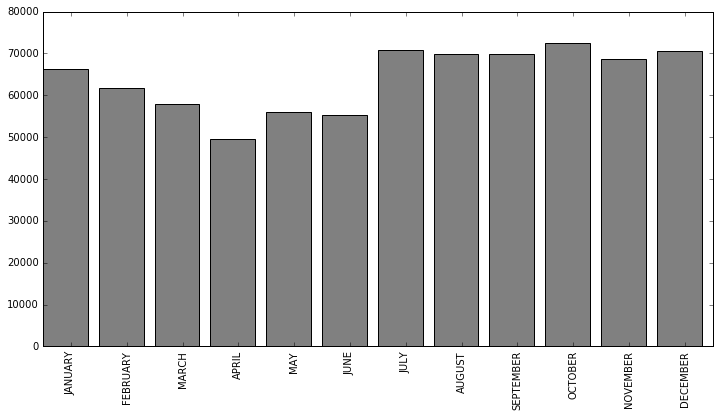

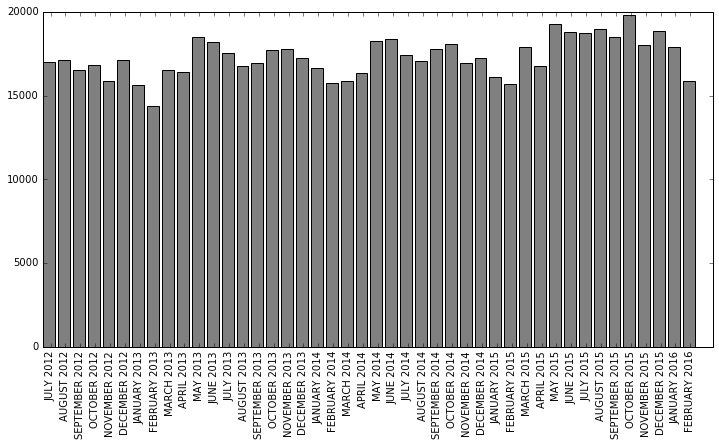

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
month_year_c = Counter(month_year)
month_c = Counter(months)
years = ['2012', '2013', '2014', '2015', '2016']
month_year_labels = []
month_values = []
month_year_values = []
for year in years:
    for month in months_label[1:]:
        month_year_labels.append(month + ' ' + year)
        month_year_values.append(month_year_c[month + ' ' + year])
        
for month in months_label[1:]:
    month_values.append(month_c[month])

%matplotlib inline
plt.figure(figsize=(12,6))
plt.bar(range(12), month_values, color='grey')
plt.xticks([a + 0.5 for a in range(12)], months_label[1:], rotation='vertical')
plt.show()

plt.figure(figsize=(12,6))
plt.bar(range(len(month_year_labels[6:-10])), month_year_values[6:-10], color='grey')
plt.xticks([a + 0.5 for a in range(len(month_year_labels[6:-10]))], month_year_labels[6:-10], rotation='vertical')
plt.show()

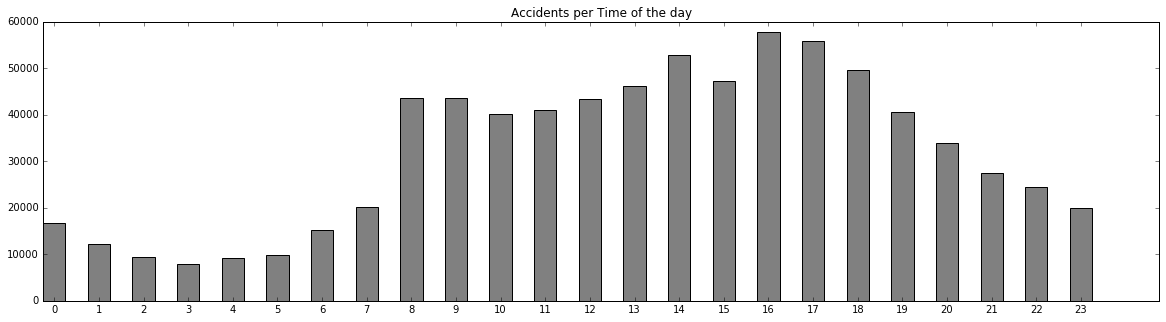

In [12]:
period_cnt = [int(x['time'].split(':')[0]) for x in data ]

periods = Counter(period_cnt)
periods = sorted(periods.items())

import matplotlib.pyplot as plt
%matplotlib inline

values = [a[1] for a in periods]
labels = [a[0] for a in periods]

indexes = np.arange(len(labels))
width = 0.5
plt.gcf().set_size_inches(20, 5)
plt.bar(indexes, values, width,color='gray')
plt.xticks(indexes + width * 0.5, labels)
plt.title('Accidents per Time of the day')
plt.show()

In [12]:
intersections = map(lambda a: a["intersection"], data)
intersections = filter(None, intersections)
c = Counter(intersections)

intersections = c.most_common()[0:100]

with open('intersections.txt', 'w') as outputFile:
    outputFile.write('intersection,borough,accidents,killed,injured\n')
    for item in intersections:
        outFile.write('"{}","{}",{},{},{}\n'.format(
                item[0],
                intersection_related_data[item[0]]['borough'],
                item[1],
                intersection_related_data[item[0]]['killed'],
                intersection_related_data[item[0]]['injured'],
            ))

In [3]:
import geoplotlib
from geoplotlib.utils import BoundingBox
#                                   
geoplotlib.set_bbox(BoundingBox(north=37.8, west=-70.5, south=37.7, east=-70.3))
                                #40.4774, west=-74.2589, south=40.9176, east=-73.7004

#geoplotlib.show()

The data is 142MB in size, has 28 columns and 769054 rows.

In [4]:
from sklearn.cluster import KMeans 
from scipy.cluster.vq import vq, whiten

Lat = [x['lat'] for x in data]
Lon = [x['lon'] for x in data]

features = zip(Lon,Lat)
features = filter(lambda x: x[0] is not None and x[1] is not None ,features)
sqrd_err = []
for k in range(2,10):
    KM = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300,
                            tol=0.0001, precompute_distances='auto', verbose=0, random_state=None,
                            copy_x=True, n_jobs=1)
    KM.fit(features)
    sqrd_err.append(KM.inertia_)

[5034.4850281881363, 3344.8631169664613, 2347.6001430566203, 1599.996018063855, 1303.4128144705317, 1121.4027172253107, 961.08316504131653, 865.09091783138092]


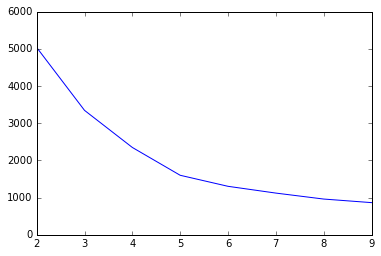

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
print sqrd_err
plt.plot(range(2,10), sqrd_err)
#plt.axis([2, 8, 0, 5])
plt.show()

4 seams to be the right amount of clusters

In [6]:
KM = [0]*3
for i in range(0,3):
    KM[i] = KMeans(n_clusters=i+3, init='k-means++', n_init=10, max_iter=300,
                            tol=0.0001, precompute_distances='auto', verbose=0, random_state=None,
                            copy_x=True, n_jobs=1)
    KM[i].fit(features)

In [7]:
np_features = np.array(features)
min_lat = np_features[:, 1].min()
max_lat = np_features[:, 1].max()
min_lon = np_features[:, 0].min()
max_lon = np_features[:, 0].max()

print min_lat
print max_lat
print min_lon
print max_lon

40.4989488
40.9128276
-74.2545316
-73.7005968


[[0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]
 ..., 
 [3 3 3 ..., 1 1 1]
 [3 3 3 ..., 1 1 1]
 [3 3 3 ..., 1 1 1]]


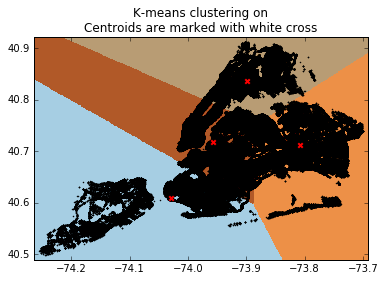

In [8]:
ep = 0.01
x_min, x_max = min_lon - ep, max_lon + ep
y_min, y_max = min_lat - ep, max_lat + ep
h=0.001
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = KM[1].predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

print Z

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(np_features[:, 0], np_features[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = KM[1].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x',  linewidths=2,
            color='r', zorder=10)
plt.title('K-means clustering on\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [108]:
accidentsCSV = []
centersCSV = []
clusterPerPoint = []
for i in range(0,3):
    clusterPerPoint.append(KM[i].predict(features))
    print i
    cntAccXclust = Counter(clusterPerPoint[i])
    centersCSV.append([[KM[i].cluster_centers_[d[0]][1],KM[i].cluster_centers_[d[0]][0],d[1]] for d in cntAccXclust.items()])
    
print centersCSV

allAccidentsCSV = [[clusterPerPoint[0][j],clusterPerPoint[1][j],clusterPerPoint[2][j],f[1],f[0]] for j,f in enumerate(features)]

0
1
2
[[[40.794958486801917, -73.930114394000299, 252234], [40.709752880757257, -73.813943870898626, 153479], [40.655697164168977, -73.988055837529117, 242154]], [[40.711315555934611, -73.807925397197181, 142214], [40.717681400473268, -73.957319826480244, 284550], [40.607821968553786, -74.030458486322985, 96150], [40.835952943272588, -73.898893396615449, 124953]], [[40.74748418705277, -73.96518348505181, 202057], [40.713293129017259, -73.80713443970501, 140509], [40.648240563672537, -73.954220777743259, 165593], [40.589559637431378, -74.130342845340394, 31698], [40.842614469167252, -73.892912188699228, 108010]]]


In [115]:
import csv

for i in range(0,3):

    with open("centers"+str(3+i)+".csv", "wb") as f:
        writer = csv.writer(f)
        writer.writerows([["Latitude","Longitude","count"]])
        writer.writerows(centersCSV[i])
with open("allcenters.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows([["cluster3","cluster4","cluster5","Latitude","Longitude"]])
    sample = random.sample(allAccidentsCSV, 10000)
    writer.writerows(sample)

In [7]:
import csv 
import numpy as np
infile = open("../../../NYPD_Motor_Vehicle_Collisions.csv", 'r')
data = csv.reader(infile, delimiter = ',')
inc = {}
incidentlist = []


for row in data:   
    inc ={'BOROUGH': row[2], 'LATITUDE':row[4], 'LONGITUDE':row[5], 'LOCATION':row[6], 
          'NUMBER OF PERSONS KILLED':row[11], 'CONTRIBUTING FACTOR VEHICLE 1':row[18], 
          'CONTRIBUTING FACTOR VEHICLE 2':row[19],'CONTRIBUTING FACTOR VEHICLE 3':row[20],
          'CONTRIBUTING FACTOR VEHICLE 4':row[21],   'CONTRIBUTING FACTOR VEHICLE 5':row[22],
          'VEHICLE TYPE CODE 1':row[24], 'VEHICLE TYPE CODE 2':row[25],'VEHICLE TYPE CODE 3':row[26],
          'VEHICLE TYPE CODE 4':row[27], 'VEHICLE TYPE CODE 5':row[28], 'TIME': row[1], 'NUMBER OF PERSONS INJURED': row[10]
         }
                                                
    incidentlist.append(inc)
    
headers = headers = ['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 
                     'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                     'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 
                     'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 
                     'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 
                     'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
                     'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']

In [8]:
incidentlist = incidentlist[1:]

In [11]:
car1 = map(lambda x: x.get('VEHICLE TYPE CODE 1'), incidentlist)   
car2 = map(lambda x: x.get('VEHICLE TYPE CODE 2'), incidentlist)
car3 = map(lambda x: x.get('VEHICLE TYPE CODE 3'), incidentlist)
car4 = map(lambda x: x.get('VEHICLE TYPE CODE 4'), incidentlist)
car5 = map(lambda x: x.get('VEHICLE TYPE CODE 5'), incidentlist)

car1 = set(car1)
car2 = set(car2)
car3 = set(car3)
car4 = set(car4)
car5 = set(car5)
car_types = filter(None, car1.union(car2, car3, car4, car5))
categories = map(lambda x: x, car_types)

categories = list(categories)
a = map(lambda x: x.get('TIME') ,incidentlist)

In [12]:
features = []
for item in incidentlist:
    
    car_types = [0 for a in range(len(categories))]
    if item.get('VEHICLE TYPE CODE 1'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 1'))] = 1
    if item.get('VEHICLE TYPE CODE 2'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 2'))] = 1
    if item.get('VEHICLE TYPE CODE 3'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 3'))] = 1
    if item.get('VEHICLE TYPE CODE 4'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 4'))] = 1
    if item.get('VEHICLE TYPE CODE 5'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 5'))] = 1   
    lat = item.get('LATITUDE')
    lon = item.get('LONGITUDE')
    time = int(item.get('TIME').split(":")[0])
    if int(item.get('TIME').split(":")[1])>30:
        time = time + 1
    
    if lat and lon:
        lat, lon = float(lat), float(lon)
        features.append(car_types + [lat] + [lon] + [time])
        
    else:
        features.append(car_types + [0] + [0] + [time]) #for empty locations I added 0


In [13]:
target = map(lambda x: max(int(x.get('NUMBER OF PERSONS KILLED')),int(x.get('NUMBER OF PERSONS INJURED'))) , incidentlist)

#print (incidentlist[0].get('NUMBER OF PERSONS KILLED'))

def inj(i):
    if i>0:
        return True
    else:
        return False
boolean_target = map(lambda x:  inj(x), target )



In [14]:
from sklearn import neighbors
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, boolean_target, test_size=0.10)

In [15]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test, y_test)
print clf.score(X_test,y_test)

0.763009388084


In [18]:
import geoplotlib 
from geoplotlib.utils import BoundingBox

bbox = BoundingBox(north=40.944336, west= -74.291151,
                   south=40.467527, east= -73.686903)

longs = np.linspace(-73.700636,-74.254073, num=70)       # grid bounds
lats = np.linspace(40.496774, 40.918385, num=70)

In [24]:
import random          
#from random import randrange, random

dangerous = filter(lambda x: x == True, boolean_target)
b_features =  []         #balanced features
b_target = []
index = []

for i in range(0, len(dangerous)):
    index = random.randint(0, len(features))       #GIORGOS, SOMETIMES IT SAYS LIST INED OUT OF RANGE!!!!!
    b_features.append(features[index])
    b_target.append(boolean_target[index])

clf1 = tree.DecisionTreeClassifier()            #train with all the dataset
clf1 = clf1.fit(b_features, b_target)

car_type = [0 for a in range(len(categories))]
car_type[categories.index('TAXI')] = 1               #choosen category taxy
acc_time = 15                                        #choosen time 

p_labels = []

for lat in lats:                                   
    for lon in longs:
        p_labels.append(car_type + [lat] + [lon] + [acc_time])
        
        
predictions = clf1.predict(p_labels)
a = filter(lambda x: x== True, predictions)


Tlat = []
Tlon = []
Flat = []
Flon = []
for i in range(0, len(predictions)):
    if predictions[i] == True:
        Tlat.append(p_labels[i][len(categories)])
        Tlon.append(p_labels[i][len(categories)+1])
    else:
        Flat.append(p_labels[i][len(categories)])
        Flon.append(p_labels[i][len(categories)+1])

red_loc = { 'lat': Tlat, 'lon': Tlon }
green_loc = { 'lat': Flat, 'lon': Flon }

print len(Tlat)

2210


In [25]:
geoplotlib.dot(red_loc, color = "red")               #prints grid
geoplotlib.dot(green_loc, color = "green") 
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

In [26]:
clf1 = tree.DecisionTreeClassifier()            #train with all the dataset
clf1 = clf1.fit(b_features, b_target)

car_type = [0 for a in range(len(categories))]
car_type[categories.index('LARGE COM VEH(6 OR MORE TIRES)')] = 1               #choosen category taxy
acc_time = 17                                                                 #choosen time 

p_labels = []

for lat in lats:                                   
    for lon in longs:
        p_labels.append(car_type + [lat] + [lon] + [acc_time])
        
        
predictions = clf1.predict(p_labels)
a = filter(lambda x: x== True, predictions)


Tlat = []
Tlon = []
Flat = []
Flon = []
for i in range(0, len(predictions)):
    if predictions[i] == True:
        Tlat.append(p_labels[i][len(categories)])
        Tlon.append(p_labels[i][len(categories)+1])
    else:
        Flat.append(p_labels[i][len(categories)])
        Flon.append(p_labels[i][len(categories)+1])

red_loc = { 'lat': Tlat, 'lon': Tlon }
green_loc = { 'lat': Flat, 'lon': Flon }

print len(Tlat)

584


In [27]:
bbox = BoundingBox(north=40.944336, west= -74.291151,
                   south=40.467527, east= -73.686903)

longs = np.linspace(-73.700636,-74.254073, num=70)       # grid bounds
lats = np.linspace(40.496774, 40.918385, num=70)
geoplotlib.dot(red_loc, color = "red")               #prints grid
geoplotlib.dot(green_loc, color = "green") 
geoplotlib.set_bbox(bbox)
geoplotlib.inline()